In [104]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

import pdb
import collections
from pathlib import Path
import json
from matplotlib import patches, patheffects
import ctoolbox
from encoder import DataEncoder

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 1. Load database

In [ ]:
root_dir = '/datasets/ee285f-public/PascalVOC2012/JPEGImages/'

In [105]:
class PascalVocDataset(td.Dataset):
    img_size = 300
    
    def __init__(self, root_dir, mode='train'):
        super(PascalVocDataset, self).__init__()
        self.root_dir = root_dir
        self.mode = mode
        self.dict= json.load( (Path().absolute()/('pascal_%s2012.json'%mode)).open())      
        # id :  bbox/class id  
        annotation=collections.defaultdict(lambda:[])
        for o in self.dict['annotations']:
            if not o['ignore']:
                bb = o['bbox']
#                 bb = hw_bb(bb)
                annotation[o['image_id']].append((bb,o['category_id']))
        self.anno = annotation
        #class 
        self.class_dict = {o['id']:o['name'] for o in self.dict['categories']}
        self.data_encoder =  DataEncoder()
        
    def __len__(self):
        return len(self.dict['images'])
    
    def __repr__(self):
        return "PascalVocDataset(mode={})".format(self.mode)
    
    def __getitem__(self, idx):
        fname = self.dict['images'][idx]['file_name']
        img_id = self.dict['images'][idx]['id']
        #pdb.set_trace()        
        img_path = os.path.join(self.root_dir, fname)
        x = Image.open(img_path).convert('RGB')        
        anno = self.anno[img_id]  
        
        D_encode =self.data_encoder
        box = []
        label = []
        for i in anno:
            box.append(i[0])
            label.append(i[1])
        w,h = x.size
        boxes_t /=torch.Tensor([w,h,w,h]).expand_as(boxes_t)
        lables_t = torch.LongTensor(label)
        
        loc_target, conf_target = D_encode(boxes_t,lables_t)
        
        x = x.resize((self.img_size,self.img_size))
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        x = transform(x) 
        d = (loc_target,conf_target)

        return x,d
    def getclass(self,idx):
        return self.class_dict[idx]
        

## 2. Draw image and bbox 

In [110]:
def myimshow(image, ax=plt):
    '''
    Accept image as tensor
    '''
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


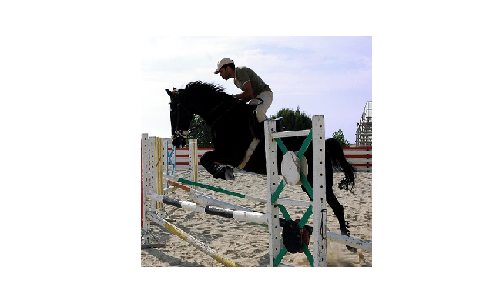

In [112]:
train_set= PascalVocDataset(root_dir)
x, anno= train_set[0]
plt.figure(figsize=(5,3))
myimshow(x)

In [119]:
anno

[([52, 86, 419, 334], 13), ([157, 43, 132, 124], 15)]

In [143]:
size = 300
w,h = 300,300
boxes_t /=torch.Tensor([w,h,w,h]).expand_as(boxes_t)

In [144]:
boxes_t

tensor([[0.1733, 0.2867, 1.3967, 1.1133],
        [0.5233, 0.1433, 0.4400, 0.4133]])

In [145]:
loc_target, conf_target = Data_encode.encode(boxes_t,lables_t)

## 3. Largest Item classifier

In [91]:
def get_lrg(b):
    if not b:
        raise Exception('trn_anno contain empty entries,can be solved by redefine trn_anno')
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [92]:
trn_lrg_anno = {a: get_lrg(b) for a,b in anno.items()}

AttributeError: 'list' object has no attribute 'items'

In [94]:
vgg = tv.models.vgg16_bn(pretrained = True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [ ]:
class VGG16Transfer(NNClassifier):
    
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
            
    def forward(self, x):
        f = self.features(x)
        f = f.view(-1, 25088)
        #print(f.size())   torch.Size([16, 25088])
        y = self.classifier(f)
        return y